# ML Workflow

A sample workflow for fitting a ML model. 

Specifically for a classification problem, but it should be relatively straight-forward to adapt it to a regression problem, as well as making the necessary changes depending on the data set being used.

**Warning**  
The dataframe "X" containing the features is being overwritten multiple times - exercise caution when running the notebook step-wise.

In [36]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, auc
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [37]:
data = load_breast_cancer()

## PreProcessing

### Split Features and Target

In [38]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [39]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [40]:
np.unique(y, return_counts=True)

(array([0, 1]), array([212, 357], dtype=int64))

### Remove Correlated Features

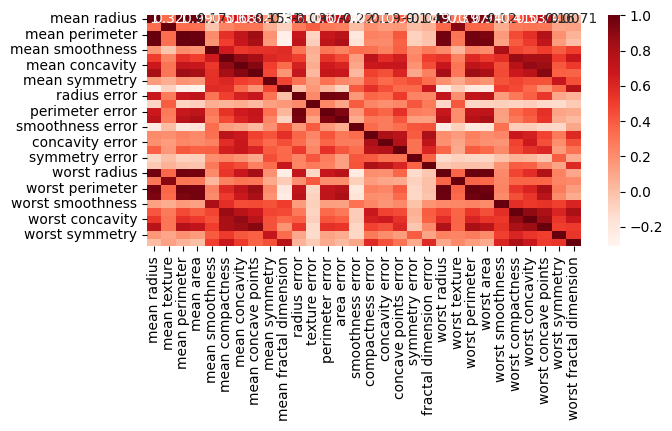

In [41]:
corr_matrix = X.corr()
plt.figure(figsize=(7, 3))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

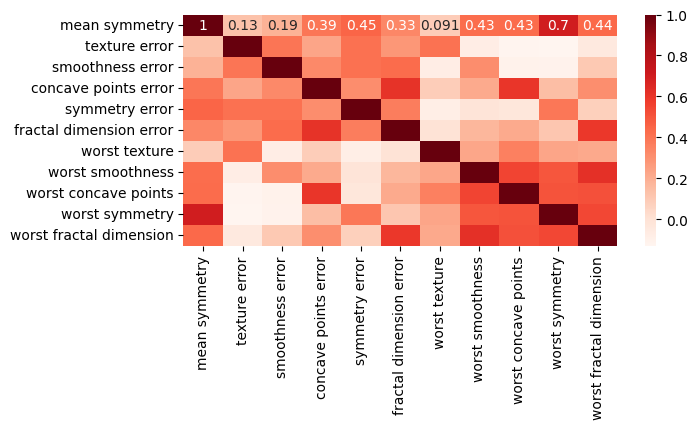

In [42]:
correlation_threshold = 0.7

# remove correlated features
mask = np.triu(corr_matrix, k=1) > correlation_threshold
corr_columns_to_remove = [col for col in X.columns if np.any(mask[X.columns.get_loc(col)])]
X = X.drop(columns=corr_columns_to_remove)

# check correlation of remaining features
plt.figure(figsize=(7, 3))
sns.heatmap(X.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

### Impute Missing Data

In [43]:
# List of columns to impute with the median
columns_median = []

# List of columns to impute with 0
columns_zero = []

# Impute columns 
for col in columns_median:
    median_value = X[col].median()
    X[col].fillna(median_value, inplace=True)
    
for col in columns_zero:
    X[col].fillna(0, inplace=True)

### Normalize Features

In [44]:
columns_normalize = X.select_dtypes(include=['number'])

scaler = MinMaxScaler()
scaled_numeric_features = scaler.fit_transform(columns_normalize)
X_scaled = pd.DataFrame(scaled_numeric_features, columns=columns_normalize.columns)
X[columns_normalize.columns] = X_scaled
X.head()

,mean symmetry,texture error,smoothness error,concave points error,symmetry error,fractal dimension error,worst texture,worst smoothness,worst concave points,worst symmetry,worst fractal dimension
0,0.686364,0.120469,0.159296,0.300625,0.311645,0.183042,0.141525,0.601136,0.912027,0.598462,0.418864
1,0.379798,0.082589,0.119387,0.253836,0.084539,0.091110,0.303571,0.347553,0.639175,0.233590,0.222878
2,0.509596,0.094303,0.150831,0.389847,0.205690,0.127006,0.360075,0.483590,0.835052,0.403706,0.213433
3,0.776263,0.175875,0.251453,0.353665,0.728148,0.287205,0.385928,0.915472,0.884880,1.000000,0.773711
4,0.378283,0.093065,0.332359,0.357075,0.136179,0.145800,0.123934,0.437364,0.558419,0.157500,0.142595


### Encode Categorical Features

LabelEncoding - suitable for ordinal variables where the order of the categories matters:

In [45]:
columns_encode_label = []

label_encoder = LabelEncoder()

for col in columns_encode_label:
    X[col] = label_encoder.fit_transform(X[col])

One-Hot Encoding - suitable for categorical variables where there is no inherent order in the categories:

In [46]:
columns_encode_onehot = []

one_hot_encoder = OneHotEncoder(sparse=False)

encoded_data = pd.DataFrame()

for column in columns_encode_onehot:
    one_hot = pd.get_dummies(X[column], prefix=column)
    encoded_data = pd.concat([encoded_data, one_hot], axis=1)

X = X.drop(columns=columns_encode_onehot)
X = pd.concat([X, encoded_data], axis = 1)

## Fit model

### Split into Train, Test and Validate 

In [47]:
perc_eval = 0.2
perc_test = 0.2

X_traintest, X_val, y_traintest, y_val = train_test_split(X, y, test_size = perc_eval, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size = perc_test, random_state = 42)

print(f"obs in X_train: {X_train.shape[0]}")
print(f"obs in y_train: {y_train.shape[0]}")
print(f"obs in X_test: {X_test.shape[0]}")
print(f"obs in X_test: {X_test.shape[0]}")
print(f"obs in X_val: {X_val.shape[0]}")
print(f"obs in y_val: {X_val.shape[0]}")
print(f"percentage of total in X_train : {round(X_train.shape[0] / X.shape[0], 1)}")
print(f"percentage of total in X_test : {round(X_test.shape[0] / X.shape[0], 1)}")
print(f"percentage of total in X_val : {round(X_val.shape[0] / X.shape[0], 1)}")

obs in X_train: 364
obs in y_train: 364
obs in X_test: 91
obs in X_test: 91
obs in X_val: 114
obs in y_val: 114
percentage of total in X_train : 0.6
percentage of total in X_test : 0.2
percentage of total in X_val : 0.2


 ### Define Algorithm

In [48]:
model = SVC(random_state=42)
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Create Pipeline and Define Values for Grid Search

In [49]:
pline = Pipeline([
    ('model', model)
])

param_grid = {
    'model__C': [0.1, 0.5, 1, 2, 5100, 120, 150, 200, 300]
}

### Hyperparameter tuning with GridSearchCV

In [50]:
grid_search = GridSearchCV(pline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_traintest, y_traintest) # why on both? cazse CV?


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.5, 1, 2, 5100, 120, 150, 200,
                                      300]})

In [51]:
# Get the best model and its parameters from GridSearchCV
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(best_model)
print(best_params)

Pipeline(steps=[('model', SVC(C=120, random_state=42))])
{'model__C': 120}


## Evaluate the model on the validation data set

In [52]:
y_pred = best_model.predict(X_val)

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8738945299705208